## Set script-wide constants

In [6]:
# 'capas', 'num_filtros', 'tam_filtros', 'num_frames'
EXP_FILE = './experiments/capas/2.pkl'

FOLDER = './datasets/train/'

CLASSES = ['n', 's', 'e', 'w', 'cw', 'aw', 't']

WINDOW = 5
ELECTRODES = 24
TACTILE_IMAGE_ROWS = 12
TACTILE_IMAGE_COLS = 11

In [7]:
import numpy as np
import pickle
import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from livelossplot import PlotLosses
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-
#glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Read train dataset and split it in train - validation

In [8]:
dataset = np.zeros((0, WINDOW, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
labels = np.zeros((0))
    
print(dataset.shape)
print(labels.shape)

for class_name in CLASSES:
    file = FOLDER + class_name + '-' + str(WINDOW) + '-ff'
    
    print(file)
    
    class_data = np.load(file + '-data-image.npy')
    class_labels = np.load(file + '-labels-image.npy')
    
    print(class_data.shape)
    print(class_labels.shape)
    
    dataset = np.append(dataset, class_data, axis=0)
    labels = np.append(labels, np.reshape(class_labels, (class_labels.shape[0])), axis=0)
    
    print(dataset.shape)
    print(labels.shape)

(0, 5, 12, 11)
(0,)
./datasets/train/n-5-ff
(880, 5, 12, 11)
(880, 1)
(880, 5, 12, 11)
(880,)
./datasets/train/s-5-ff
(888, 5, 12, 11)
(888, 1)
(1768, 5, 12, 11)
(1768,)
./datasets/train/e-5-ff
(885, 5, 12, 11)
(885, 1)
(2653, 5, 12, 11)
(2653,)
./datasets/train/w-5-ff
(828, 5, 12, 11)
(828, 1)
(3481, 5, 12, 11)
(3481,)
./datasets/train/cw-5-ff
(885, 5, 12, 11)
(885, 1)
(4366, 5, 12, 11)
(4366,)
./datasets/train/aw-5-ff
(883, 5, 12, 11)
(883, 1)
(5249, 5, 12, 11)
(5249,)
./datasets/train/t-5-ff
(883, 5, 12, 11)
(883, 1)
(6132, 5, 12, 11)
(6132,)


(array([0.1674277 , 0.16894977, 0.168379  , 0.15753425, 0.168379  ,
        0.16799848, 0.16799848]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

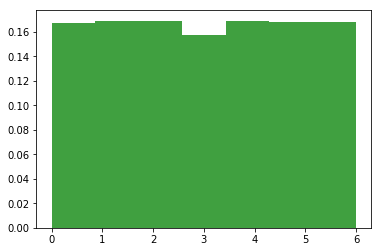

In [9]:
plt.hist(labels, bins=len(CLASSES), density=True, facecolor='g', alpha=0.75)

In [10]:
# Reshape data to include channels: batch, time, channels, height (rows), width (cols) 
CHANNELS = 1

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], CHANNELS, dataset.shape[2], dataset.shape[3]))

print('Dataset reshaped')
print(dataset.shape)

Dataset reshaped
(6132, 5, 1, 12, 11)


## Define ConvLSTM and train

In [11]:
#https://github.com/automan000/Convolution_LSTM_PyTorch

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.bias = bias
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding,  bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))

In [12]:
class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_sizes, num_classes, sequence_length,
                 dropout=0.25, bias=True):
        super(ConvLSTM, self).__init__()
        
        assert len(hidden_channels) == len(kernel_sizes)
        
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.num_layers = len(hidden_channels)
        self.sequence_length = sequence_length
        self.bias = bias
        self._all_layers = []
        
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_sizes[i], self.bias)
            
            setattr(self, name, cell)
            self._all_layers.append(cell)
            
            print(name)
            print(cell)
        
        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721
        self.avg_pool2d = nn.AvgPool2d((TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
        self.fc1 = nn.Linear(hidden_channels[-1], hidden_channels[-1])
        self.fc1_bn = nn.BatchNorm1d(hidden_channels[-1])
        self.fc1_drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, input):
        internal_state = []
        outputs = []
        
        for step in range(self.sequence_length):
            #print('#### step ', step)
            x = input[:, step, :, :, :]
            
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                
                if step == 0:
                    #print('init hidden')
                    #print('input', x.shape)
                    #print(name)
                    
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i], 
                                                             shape=(height, width))
                    #print('h', h.shape)
                    #print('c', c.shape)
                    
                    internal_state.append((h, c))
                    
                    #print('internal_state', len(internal_state))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
                
            # only record last steps
            #if step == self.sequence_length - 1:
            #    outputs.append(x)
            #    print('output', x.shape)
                
        #return outputs, (x, new_c)
        
        # Get last step and pass it to classifier
        out = self.avg_pool2d(x)
        out = torch.squeeze(out)
        #out = F.relu(self.fc1_bn(self.fc1(out)))
        out = F.relu(self.fc1(out))
        out = self.fc1_drop(out)
        out = self.fc2(out)

        return out

In [ ]:
FOLDS = 5
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True)

cv_train_indices = []
cv_val_indices = []

cv_loss_history = []
cv_loss_history_val = []
cv_accuracy_history = []
cv_accuracy_history_val = []

cv_precision = []
cv_recall = []
cv_f1_score = []
cv_conf_matrix = []

cv_models_dict = {}

for index, (train_indices, val_indices) in enumerate(kfold.split(dataset, labels)):
    cv_train_indices.append(train_indices)
    cv_val_indices.append(val_indices)
        
    # split data
    data_train = np.copy(dataset)
    labels_train = np.copy(labels)
    
    data_val = np.copy(dataset)
    labels_val = np.copy(labels)
    
    # Changed for using GPU
    data_val = torch.from_numpy(data_val)
    data_val = data_val.to(device, dtype=torch.float)

    labels_val = torch.from_numpy(labels_val)
    labels_val = labels_val.to(device, dtype=torch.long)
    
    # Train parameters
    epochs = 30
    batch = 32
    
    loss_history = []
    loss_history_val = []
    acc_history = []
    acc_history_val = []

    steps = math.ceil(data_train.shape[0] / batch)
    print('Epochs:', epochs, 'Batch:', batch, 'Steps:', steps)

    liveloss = PlotLosses()
    
    # Create ConvLSTM
    hidden_channels = [16, 16]
    kernel_sizes = [3, 3]
    dropout = 0.0

    convlstm = ConvLSTM(input_channels=CHANNELS, hidden_channels=hidden_channels, kernel_sizes=kernel_sizes,
                        num_classes=len(CLASSES), sequence_length=WINDOW, dropout=dropout).to(device)

    # Loss and optimizer
    learning_rate = 0.001
    l2_reg = 0.00
    step_size = 60
    lr_decay = 0.5

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(convlstm.parameters(), lr=learning_rate, weight_decay=l2_reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=lr_decay)

    for epoch in range(epochs):  # loop over the dataset multiple times
        print('===== (', str(index + 1), '/', FOLDS, ') - epoch', epoch + 1, '=====')

        scheduler.step()
        epoch_loss = 0.0
        epoch_loss_val = 0.0
        epoch_correct = 0

        for param_group in optimizer.param_groups:
            print('>> lr:', param_group['lr'])

        # Shuffle dataset so epochs receive data in batches with different order
        data_train, labels_train = shuffle(data_train, labels_train)

        for i in range(steps):
            # get the inputs
            #batch, time, channels, height, width
            batch_data = torch.from_numpy(data_train[batch * i : batch * i + batch])
            batch_labels = torch.from_numpy(labels_train[batch * i : batch * i + batch])

            # Changed for using GPU
            batch_data = batch_data.to(device, dtype=torch.float)
            batch_labels = batch_labels.to(device, dtype=torch.long)

            # Forward pass
            import time
            
            start = time.time()
            outputs = convlstm(batch_data)
            end = time.time()
            print("Elapsed:", end-start)
            loss = criterion(outputs, batch_labels)

            epoch_loss += loss.data[0]
            epoch_correct += (outputs.max(1)[1] == batch_labels).sum().data[0]

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}'.format(epoch + 1, epochs, i + 1, steps, loss.item()))

        loss_history.append(epoch_loss / steps)
        acc_history.append(epoch_correct.item() / (steps * batch) * 100)

        with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
            outputs_val = convlstm(data_val)
            loss = criterion(outputs_val, labels_val)

            epoch_loss_val = loss.data[0]

            _, predicted_val = torch.max(outputs_val.data, 1)
            total = labels_val.size(0)
            epoch_correct_val = (predicted_val == labels_val).sum().item()

        loss_history_val.append(epoch_loss_val)
        acc_history_val.append((epoch_correct_val / total) * 100)

        liveloss.update({
            'log loss': loss_history[-1],
            'val_log loss': loss_history_val[-1],
            'accuracy': acc_history[-1],
            'val_accuracy': acc_history_val[-1]
        })
        liveloss.draw()
    
    cv_models_dict['fold-' + str(index)] = convlstm.state_dict()
    
    cv_loss_history.append(loss_history)
    cv_loss_history_val.append(loss_history_val)
    cv_accuracy_history.append(acc_history)
    cv_accuracy_history_val.append(acc_history_val)
        
    # Evaluate fold on validation set
    with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
        outputs_val = convlstm(data_val)

    _, predicted_val = torch.max(outputs_val.data, 1)

    total = labels_val.size(0)
    correct = (predicted_val == labels_val).sum().item()
    score = correct / total

    [precision, recall, f1_score, _] = precision_recall_fscore_support(labels_val, predicted_val, average=None,
                                                                       pos_label=1)
    
    cnf_matrix = confusion_matrix(labels_val, predicted_val)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    cv_conf_matrix.append(cnf_matrix)

Epochs: 30 Batch: 32 Steps: 192
cell0
ConvLSTMCell(
  (Wxi): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whi): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxf): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whf): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxc): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whc): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxo): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Who): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
cell1
ConvLSTMCell(
  (Wxi): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whi): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxf): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whf): Conv2d(16, 16, kernel_size=(3, 3), s

C:\Users\Brayan\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Brayan\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:103: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Elapsed: 0.03092050552368164
Elapsed: 0.028925180435180664
Elapsed: 0.02293848991394043
Elapsed: 0.037897348403930664
Elapsed: 0.022937774658203125
Elapsed: 0.022938966751098633
Elapsed: 0.022937774658203125
Elapsed: 0.03092193603515625
Epoch [1/30], Step [10/192], Loss: 1.939571
Elapsed: 0.02992081642150879
Elapsed: 0.029906749725341797
Elapsed: 0.030913829803466797
Elapsed: 0.02792501449584961
Elapsed: 0.02293848991394043
Elapsed: 0.027924299240112305
Elapsed: 0.022938966751098633
Elapsed: 0.024933338165283203
Elapsed: 0.03390932083129883
Elapsed: 0.028924226760864258
Epoch [1/30], Step [20/192], Loss: 1.954653
Elapsed: 0.03291034698486328
Elapsed: 0.022938251495361328
Elapsed: 0.022938966751098633
Elapsed: 0.027925491333007812
Elapsed: 0.02293872833251953
Elapsed: 0.022939443588256836
Elapsed: 0.022938251495361328
Elapsed: 0.022938251495361328
Elapsed: 0.022937774658203125
Elapsed: 0.022938013076782227
Epoch [1/30], Step [30/192], Loss: 1.967641
Elapsed: 0.028923749923706055
Elapsed

In [11]:
print("\n@ Final cross-validation score @")
print(np.mean(np.array(cv_accuracy_history)[:, -1]), "+/-", np.std(np.array(cv_accuracy_history)[:, -1]))
print(np.mean(np.array(cv_precision), axis=0), "+/-", np.std(np.array(cv_precision), axis=0))
print(np.mean(np.array(cv_recall), axis=0), "+/-", np.std(np.array(cv_recall), axis=0))
print(np.mean(np.array(cv_f1_score), axis=0), "+/-", np.std(np.array(cv_f1_score), axis=0))


@ Final cross-validation score @
87.77994791666666 +/- 1.692282598705135
[98.04212673 99.04306397 99.684583   97.27848657 76.11459531 79.8089522
 82.77751907] +/- [1.42906889 0.49555062 0.33705914 1.0387807  8.00950754 8.8358513
 5.90533457]
[99.13636364 97.20720721 99.54751131 99.51690821 83.57466063 67.3015873
 84.71655329] +/- [ 1.06017307  2.1442577   0.70099246  0.62987463  4.36973834  7.38463496
 10.16682541]
[98.57871743 98.10177099 99.61416582 98.37813463 79.38259478 72.74070067
 83.49716   ] +/- [0.92273974 1.02969441 0.34985579 0.26873461 5.20224555 6.81518499
 6.83543214]


## Save experiment data

In [12]:
with open(EXP_FILE, 'wb+') as f:
    # Train set information
    pickle.dump(FOLDER, f)
    pickle.dump(CLASSES, f)

    pickle.dump(WINDOW, f)
    pickle.dump(ELECTRODES, f)
    pickle.dump(TACTILE_IMAGE_ROWS, f)
    pickle.dump(TACTILE_IMAGE_COLS, f)

    # Model information
    pickle.dump(hidden_channels, f)
    pickle.dump(kernel_sizes, f)
    pickle.dump(dropout, f)
    pickle.dump(learning_rate, f)
    pickle.dump(l2_reg, f)
    pickle.dump(step_size, f)
    pickle.dump(lr_decay, f)

    # Training information
    pickle.dump(FOLDS, f)
    pickle.dump(cv_train_indices, f)
    pickle.dump(cv_val_indices, f)

    pickle.dump(cv_loss_history, f)
    pickle.dump(cv_loss_history_val, f)
    pickle.dump(cv_accuracy_history, f)
    pickle.dump(cv_accuracy_history_val, f)

    pickle.dump(cv_precision, f)
    pickle.dump(cv_recall, f)
    pickle.dump(cv_f1_score, f)
    pickle.dump(cv_conf_matrix, f)

In [13]:
torch.save(cv_models_dict, EXP_FILE + '.pt')